In [26]:
import iris
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
%matplotlib widget


In [2]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


Download example data:

In [5]:
import urllib
file_path='http://gws-access.ceda.ac.uk/public/acpc/mheiken/Tracking/Small_Example/Example_Updraft/Example_input.nc'
data_dir='Data'
os.makedirs(data_dir,exist_ok=True)
data_file=os.path.join(data_dir,'data.nc')
request=urllib.request.urlretrieve(file_path,data_file)

Load Data from downloaded file:

In [6]:
W=iris.load_cube(data_file,'w')
TWC=iris.load_cube(data_file,'TWC')

In [7]:
from iris.analysis import MAX
from iris import Constraint
W_max=W.collapsed(('model_level_number'),MAX)
constraint_midlevel=Constraint(model_level_number= lambda cell: 30 < cell < 48)
W_mid = W.extract(constraint_midlevel) # get midlevel data
W_mid_max = W_mid.collapsed('model_level_number',MAX) # get Maximum column updraft in mid-level data


In [8]:
savedir='Save'
os.makedirs(savedir,exist_ok=True)


In [27]:
import tobac
#switch to info for less detailed output from tobac
%config tobac.log_level="DEBUG"
#%config tobac.log_level="INFO"
from tobac import get_spacings,feature_detection_multithreshold,segmentation_3D,linking_trackpy


In [10]:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=3
parameters_features['min_distance']=0
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[3,5,10] #m/s
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=3



In [11]:
dxy,dt=get_spacings(W_mid_max)
Features=feature_detection_multithreshold(W_mid_max,dxy,**parameters_features)
Features.to_hdf(os.path.join(savedir,'Features.h5'),'table')

In [12]:
#setup for saving masks:                        
zlib=True
#zlib=False
# Set to compression level
complevel=4
packing=None
chunksizes=None
packing={'dtype': np.int32, 'scale_factor':1, 'add_offset':1}

In [13]:
parameters_segmentation_TWC={}
parameters_segmentation_TWC['method']='watershed'
parameters_segmentation_TWC['threshold']=0.1e-3  # kg/kg mixing ratio


In [14]:
#perform 3D segmentation based on total condenate
Mask_TWC,Features_TWC=segmentation_3D(Features,TWC,dxy,**parameters_segmentation_TWC)
chunksizes=list(Mask_TWC.shape)
chunksizes[0]=1
logging.debug('segmentation TWC performed, start saving results to files')
iris.save([Mask_TWC],os.path.join(savedir,'Mask_Segmentation_TWC.nc'),zlib=zlib,complevel=complevel,packing=packing,chunksizes=chunksizes)                
Features_TWC.to_hdf(os.path.join(savedir,'Features_TWC.h5'),'table')
logging.debug('segmentation TWC performed and saved')


2018-11-15 17:35:13,211 | INFO : Start watershedding 3D


In [15]:
parameters_segmentation_w={}
parameters_segmentation_w['method']='watershed'
parameters_segmentation_w['threshold']=3 # m/s


In [16]:
# perform 3D segmentation based on uodraft:
Mask_w,Features_w=segmentation_3D(Features,W,dxy,**parameters_segmentation_w)
logging.debug('segmentation w performed, start saving results to files')
iris.save([Mask_w],os.path.join(savedir,'Mask_Segmentation_w.nc'),zlib=zlib,complevel=complevel,packing=packing,chunksizes=chunksizes)
Features_w.to_hdf(os.path.join(savedir,'Features_w.h5'),'table')
logging.debug('segmentation w performed and saved')

2018-11-15 17:38:17,713 | INFO : Start watershedding 3D


In [17]:
# perform 3D segmentation based on updraft velocity and TWC
logging.info('start watershedding w with TWC masking')
# Set field to zero for TWC below threshold
if (W.shape==TWC.shape):
    W_TWC=W*(TWC.core_data()>parameters_segmentation_TWC['threshold'])
# Workaround for WRF, where W is on a staggered grid...
elif (W.shape[1]==(TWC.shape[1]+1)):
    W_TWC=W[:,:-1]*(TWC.core_data()>parameters_segmentation_TWC['threshold'])
Mask_w_TWC,Features_w_TWC=segmentation_3D(Features,W_TWC,dxy,**parameters_segmentation_w)
logging.debug('segmentation w_TWC performed, start saving results to files')
iris.save([Mask_w_TWC],os.path.join(savedir,'Mask_Segmentation_w_TWC.nc'),zlib=zlib,complevel=complevel,chunksizes=chunksizes)
Features_w_TWC.to_hdf(os.path.join(savedir,'Features_w_TWC.h5'),'table')
logging.debug('segmentation w_TWC performed and saved')


2018-11-15 17:41:16,658 | INFO : start watershedding w with TWC masking
2018-11-15 17:41:55,762 | INFO : Start watershedding 3D


In [18]:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10
parameters_linking['d_min']=2000


In [19]:
Track=linking_trackpy(Features,W_mid_max,dt=dt,dxy=dxy,**parameters_linking)
#save trajectories:
Track.to_hdf(os.path.join(savedir,'Track.h5'),'table')


Frame 10: 25 trajectories present.


Plot some results for a specific timestep:
    

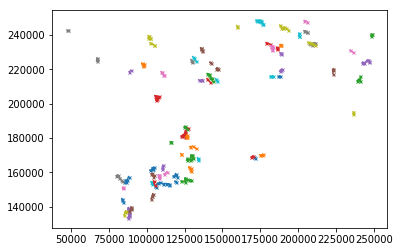

In [24]:
fig1,ax1=plt.subplots()
for cell in Track['cell'].dropna().unique():
    Track_i=Track[Track['cell']==cell]
    ax1.plot(Track_i['projection_x_coordinate'],Track_i['projection_y_coordinate'],'-x',markersize=3)

In [21]:
plot_dir="Plots_Updraft"
os.makedirs(plot_dir,exist_ok=True)


TypeError: op_getitem expected 2 arguments, got 4

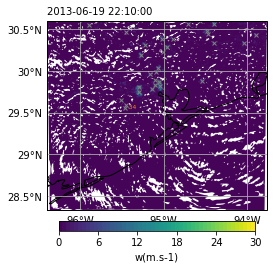

In [22]:
from tobac import plot_tracks_mask_field_loop
axis_extent=[-96.3,-93.9,28.4,30.5]
plot_tracks_mask_field_loop(track=Track,field=W_mid_max,mask=Mask_TWC,features=Features,
                            plot_dir=plot_dir,name='w_max_Mask_TWC',
                            axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                            vmin=0,vmax=30,
                            plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)
        
